# Document Classifier

### Author: Erick Orozco

In [115]:
# general packages 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import spacy
import re

# general ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss

# BERT
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD

## Prep Text into Data Frames

In [116]:
# save important information
text      = []
label     = []
directory = []
header    = []

filepath = 'data/textfiles/'

# walk through filepath and sort information
for curr_directory,_,files in os.walk(filepath):
    if files[0] == 'README.TXT':
        _
    else:
        for file in files: 
            directory.append(curr_directory+'/'+file)
            label.append(curr_directory.split('/')[-1])
            with open(directory[-1],'r',) as f:
                body = ''
                first = ''
                for line in f:
                    if first == '':
                        first = line
                        header.append(line.strip())
                    else:
                        body = body+line.strip()
                text.append(body)

# assemble data into df 
all_df = pd.DataFrame(list(zip(directory,header,text,label)),columns=['directory','header','text','label'])

df = all_df[['text','label']]

df.head()

,text,label
0,Quarterly profits at US media giant TimeWarner...,business
1,The dollar has hit its highest level against t...,business
2,The owners of embattled Russian oil giant Yuko...,business
3,British Airways has blamed high fuel prices fo...,business
4,Shares in UK drinks and food firm Allied Domec...,business


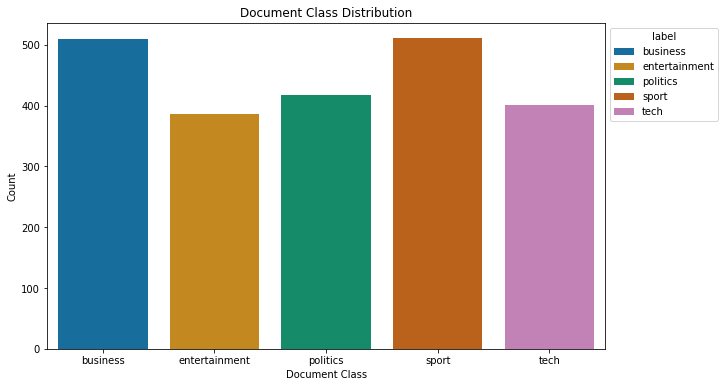

In [117]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette('colorblind')
chart = sns.countplot(x='label',data=df,hue='label',dodge=False,palette=palette)
chart.set(xlabel='Document Class', ylabel='Count',title='Document Class Distribution')
sns.move_legend(chart, "upper left", bbox_to_anchor=(1, 1))

In [118]:
# convert labels to unique integer values
df['label'] = LabelEncoder().fit_transform(df['label'])
df.head()

,text,label
0,Quarterly profits at US media giant TimeWarner...,0
1,The dollar has hit its highest level against t...,0
2,The owners of embattled Russian oil giant Yuko...,0
3,British Airways has blamed high fuel prices fo...,0
4,Shares in UK drinks and food firm Allied Domec...,0


In [119]:
# general text preprocessing

#stop_words = set(stopwords.words('english'))
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')
replace_space = re.compile('[/(){}\[\]\|@,;]')
replace_blank = re.compile('[^0-9a-z #+_]')


# input: unprocessed text
# output: processed text
def text_cleaner(txt):
    txt = txt.lower()
    txt = replace_space.sub(' ',txt)
    txt = replace_blank.sub('',txt)
    txt = ' '.join(item.text for item in nlp(txt) if not item.is_stop)
    return txt

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [120]:
# preprocess text
df['text'] = df['text'].apply(text_cleaner)

# split data train & test sets
x_train,x_test,y_train,y_test=train_test_split(df['text'],df['label'],test_size=0.20,\
                                               random_state=0,stratify=df['label'])


## TF-IDF for Traditional ML models


In [121]:
# tfidf vectors

vec = TfidfVectorizer()

## Multinomial Naive Bayes

In [112]:
# pipeline construction for 
nb_pipe = Pipeline([
    ('tf-idf', vec),
    ('clf', MultinomialNB()),
])